In [1]:
# -*- coding:utf-8 _*-
import math
import cv2
from PIL import Image, ImageDraw
from matplotlib.pyplot import imshow
import face_recognition
from collections import defaultdict
import numpy as np
import os
import glob

class FaceCropper(object):
    CASCADE_PATH = "/home/lingyi/Desktop/finalize_model/haarcascade_frontalface_default.xml"

    def __init__(self):
        print(self.CASCADE_PATH)
        self.face_cascade = cv2.CascadeClassifier("/home/lingyi/Desktop/finalize_model/haarcascade_frontalface_default.xml"
)
        

    def generate(self, img, show_result=False, d = 0):
        # img = cv2.imread(image_path)
        if (img is None):
            print("Can't open image file")
            return 0

        #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(img, 1.1, 5, minSize=(100, 100))
        facecnt = len(faces)
        print("Detected faces: %d" % facecnt)

        if (faces is None):
            print('Failed to detect face')
            return 0
        elif len(faces) > 1:
            eval = []

            # solve the issue when there are multiple detection
            for face in faces:
                x,y,w,h = face
                r = max(w, h) / 2
                size = r*2
                eval.append(size)
            ind = eval.index(max(eval))
            faces = faces.tolist()
            faces = [faces[ind]]

        # zoom a bit more than usual
        for (x, y, w, h) in faces:
            newx, newy,neww,newh = x+d,y+d,w-d,h-d
            r = max(neww, newh) / 2
            centerx = newx + neww / 2
            centery = newy + newh / 2
            nx = int(centerx - r)
            ny = int(centery - r)
            nr = int(r * 2)
            faceimg = img[ny:ny+nr, nx:nx+nr]
            lastimg = cv2.resize(faceimg, (48, 48))

            return lastimg

        if (show_result):
            for (x, y, w, h) in faces:
                newx, newy, neww, newh = x, y, w - d, h - d
                cv2.rectangle(img, (newx, newy), (newx+neww, newy+newh), (255,0,0), 2)
            cv2.imshow('img', img)
            cv2.waitKey(0)
            cv2.destroyAllWindows()


        # if store_result:
        #     cv2.imwrite("image%d.jpg" % i, faceimg)
        #     print("image is stored.")
    
def detect_landmark(image_array, model_type="large"):
    """ return landmarks of a given image array
    :param image_array: numpy array of a single image
    :param model_type: 'large' returns 68 landmarks; 'small' return 5 landmarks
    :return: dict of landmarks for facial parts as keys and tuple of coordinates as values
    """
    face_landmarks_list = face_recognition.face_landmarks(image_array, model=model_type)
    face_landmarks_list = face_landmarks_list[0]
    return face_landmarks_list

def align_face(image_array, landmarks):
    """ align faces according to eyes position
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    rotated_img:  numpy array of aligned image
    eye_center: tuple of coordinates for eye center
    angle: degrees of rotation
    """
    # get list landmarks of left and right eye
    left_eye = landmarks['left_eye']
    right_eye = landmarks['right_eye']
    # calculate the mean point of landmarks of left and right eye
    left_eye_center = np.mean(left_eye, axis=0).astype("int")
    right_eye_center = np.mean(right_eye, axis=0).astype("int")
    # compute the angle between the eye centroids
    dy = right_eye_center[1] - left_eye_center[1]
    dx = right_eye_center[0] - left_eye_center[0]
    # compute angle between the line of 2 centeroids and the horizontal line
    angle = math.atan2(dy, dx) * 180. / math.pi
    # calculate the center of 2 eyes
    eye_center = ((left_eye_center[0] + right_eye_center[0]) // 2,
                  (left_eye_center[1] + right_eye_center[1]) // 2)
    # at the eye_center, rotate the image by the angle
    rotate_matrix = cv2.getRotationMatrix2D(eye_center, angle, scale=1)
    rotated_img = cv2.warpAffine(image_array, rotate_matrix, (image_array.shape[1], image_array.shape[0]))
    return rotated_img, eye_center, angle

def rotate(origin, point, angle, row):
    """ rotate coordinates in image coordinate system
    :param origin: tuple of coordinates,the rotation center
    :param point: tuple of coordinates, points to rotate
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated coordinates of point
    """
    x1, y1 = point
    x2, y2 = origin
    y1 = row - y1
    y2 = row - y2
    angle = math.radians(angle)
    x = x2 + math.cos(angle) * (x1 - x2) - math.sin(angle) * (y1 - y2)
    y = y2 + math.sin(angle) * (x1 - x2) + math.cos(angle) * (y1 - y2)
    y = row - y
    return int(x), int(y)

def rotate_landmarks(landmarks, eye_center, angle, row):
    """ rotate landmarks to fit the aligned face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param eye_center: tuple of coordinates for eye center
    :param angle: degrees of rotation
    :param row: row size of the image
    :return: rotated_landmarks with the same structure with landmarks, but different values
    """
    rotated_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            rotated_landmark = rotate(origin=eye_center, point=landmark, angle=angle, row=row)
            rotated_landmarks[facial_feature].append(rotated_landmark)
    return rotated_landmarks

def corp_face(image_array, size, landmarks):
    """ crop face according to eye,mouth and chin position
    :param image_array: numpy array of a single image
    :param size: single int value, size for w and h after crop
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return:
    cropped_img: numpy array of cropped image
    left, top: left and top coordinates of cropping
    """
    x_min = np.min(landmarks['chin'], axis=0)[0]
    x_max = np.max(landmarks['chin'], axis=0)[0]
    x_center = (x_max - x_min) / 2 + x_min
    left, right = (x_center - size / 2, x_center + size / 2)

    eye_landmark = landmarks['left_eye'] + landmarks['right_eye']
    eye_center = np.mean(eye_landmark, axis=0).astype("int")
    lip_landmark = landmarks['top_lip'] + landmarks['bottom+lip']
    lip_center = np.mean(lip_landmark, axis=0).astype("int")
    mid_part = lip_center[1] - eye_center[1]
    top, bottom = eye_center[1] - (size - mid_part) / 2, lip_center[1] + (size - mid_part) / 2

    pil_img = Image.fromarray(image_array)
    left, top, right, bottom = [int(i) for i in [left, top, right, bottom]]
    cropped_img = pil_img.crop((left, top, right, bottom))
    cropped_img = np.array(cropped_img)
    return cropped_img, left, top

def transfer_landmark(landmarks, left, top):
    """transfer landmarks to fit the cropped face
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :param left: left coordinates of cropping
    :param top: top coordinates of cropping
    :return: transferred_landmarks with the same structure with landmarks, but different values
    """
    transferred_landmarks = defaultdict(list)
    for facial_feature in landmarks.keys():
        for landmark in landmarks[facial_feature]:
            transferred_landmark = (landmark[0] - left, landmark[1] - top)
            transferred_landmarks[facial_feature].append(transferred_landmark)
    return transferred_landmarks

def face_preprocess(image, landmark_model_type='large', crop_size=140):
    """ for a given image, do face alignment and crop face
    :param image: numpy array of a single image
    :param landmark_model_type: 'large' returns 68 landmarks; 'small' return 5 landmarks
    :param crop_size: ingle int value, size for w and h after crop
    :return:
    cropped_face: image array with face aligned and cropped
    transferred_landmarks: landmarks that fit cropped_face
    """
    # detect landmarks
    face_landmarks_dict = detect_landmark(image_array=image, model_type=landmark_model_type)
    # rotate image array to align face
    aligned_face, eye_center, angle = align_face(image_array=image, landmarks=face_landmarks_dict)
    # rotate landmarks coordinates to fit the aligned face
    rotated_landmarks = rotate_landmarks(landmarks=face_landmarks_dict,
                                         eye_center=eye_center, angle=angle, row=image.shape[0])
    # crop face according to landmarks
    cropped_face, left, top = corp_face(image_array=aligned_face, size=crop_size, landmarks=rotated_landmarks)
    # transfer landmarks to fit the cropped face
    transferred_landmarks = transfer_landmark(landmarks=rotated_landmarks, left=left, top=top)
    return cropped_face, transferred_landmarks

def visualize_landmark(image_array, landmarks):
    """ plot landmarks on image
    :param image_array: numpy array of a single image
    :param landmarks: dict of landmarks for facial parts as keys and tuple of coordinates as values
    :return: plots of images with landmarks on
    """
    origin_img = Image.fromarray(image_array)
    draw = ImageDraw.Draw(origin_img)
    for facial_feature in landmarks.keys():
        draw.point(landmarks[facial_feature])
    imshow(origin_img)
    
    
def image_padding(im_pth):
    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [255, 255, 255]
    image_array = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    return(image_array)

if __name__=='__main__':
    desired_size = 72
    image_path = "/home/lingyi/Desktop/finalize_model/data/all_data2500"
    destination = "/home/lingyi/Desktop/finalize_model/data/data_cropped_alignment_72_48"
    if not os.path.isdir(destination):
        os.makedirs(destination)
    if os.path.isdir(image_path):
        file_names = glob.glob(image_path+"/*.jpg")
        faceDetector = FaceCropper()
        for name in file_names:
            print(name)
            image_array = image_padding(name)
            face,landmarks = face_preprocess(image = image_array,
                                    landmark_model_type='large',
                                    crop_size=48)
            # result = faceDetector.generate(face)
            resname = destination + "/" + os.path.basename(name)
            cv2.imwrite(resname,face)
        print("The Face Chopping Step 1 is done!")

# https://zhuanlan.zhihu.com/p/55479744

/home/lingyi/Desktop/finalize_model/haarcascade_frontalface_default.xml
/home/lingyi/Desktop/finalize_model/data/all_data2500/2020.jpg


IndexError: list index out of range

In [34]:
desired_size = 96
image_array = image_padding("/home/lingyi/Desktop/finalize_model/data/all_data2500/0889.jpg")
# face,landmarks = face_preprocess(image = image_array,
#                                     landmark_model_type='large',
#                                     crop_size=48)

face_landmarks_list = face_recognition.face_landmarks(image_array, model="large")

In [35]:
face_landmarks_list

[{'chin': [(44, 47),
   (44, 51),
   (45, 55),
   (46, 60),
   (48, 63),
   (50, 66),
   (53, 69),
   (56, 71),
   (60, 72),
   (63, 71),
   (67, 69),
   (69, 66),
   (72, 62),
   (73, 58),
   (74, 54),
   (74, 50),
   (74, 46)],
  'left_eyebrow': [(46, 44), (48, 42), (51, 42), (53, 42), (56, 44)],
  'right_eyebrow': [(62, 43), (64, 42), (67, 41), (69, 41), (71, 43)],
  'nose_bridge': [(59, 47), (59, 50), (59, 53), (59, 56)],
  'nose_tip': [(56, 57), (58, 58), (59, 58), (61, 58), (62, 57)],
  'left_eye': [(50, 48), (51, 47), (53, 47), (55, 48), (53, 49), (51, 49)],
  'right_eye': [(63, 48), (64, 47), (66, 47), (68, 48), (66, 48), (64, 48)],
  'top_lip': [(53, 61),
   (55, 60),
   (58, 60),
   (59, 60),
   (61, 60),
   (63, 60),
   (66, 60),
   (65, 60),
   (61, 61),
   (59, 61),
   (58, 61),
   (54, 61)],
  'bottom_lip': [(66, 60),
   (64, 63),
   (62, 65),
   (60, 65),
   (58, 65),
   (55, 64),
   (53, 61),
   (54, 61),
   (58, 63),
   (60, 63),
   (61, 63),
   (65, 60)]}]

In [27]:
face_landmarks_list

[{'chin': [(64, 71),
   (65, 78),
   (66, 84),
   (68, 89),
   (70, 95),
   (73, 99),
   (78, 103),
   (83, 106),
   (88, 107),
   (93, 106),
   (97, 102),
   (101, 97),
   (104, 92),
   (105, 86),
   (106, 80),
   (107, 74),
   (107, 68)],
  'left_eyebrow': [(67, 66), (70, 63), (74, 62), (78, 62), (82, 62)],
  'right_eyebrow': [(89, 62), (93, 60), (97, 60), (101, 60), (104, 63)],
  'nose_bridge': [(86, 67), (86, 70), (86, 74), (87, 77)],
  'nose_tip': [(83, 81), (85, 82), (87, 82), (89, 81), (91, 81)],
  'left_eye': [(72, 68), (74, 66), (77, 66), (80, 68), (77, 69), (74, 69)],
  'right_eye': [(91, 67), (94, 65), (97, 65), (99, 66), (97, 67), (94, 67)],
  'top_lip': [(80, 93),
   (82, 89),
   (85, 87),
   (87, 87),
   (89, 86),
   (92, 88),
   (94, 92),
   (93, 92),
   (89, 89),
   (87, 89),
   (85, 89),
   (81, 92)],
  'bottom_lip': [(94, 92),
   (93, 96),
   (90, 98),
   (87, 99),
   (85, 99),
   (82, 97),
   (80, 93),
   (81, 92),
   (85, 95),
   (87, 95),
   (89, 94),
   (93, 92)]}

In [36]:
"""
plot confusion_matrix of fold Test set of CK+
"""
import transforms as transforms

import argparse
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix


from SPLIT import SPLIT
from models import *

parser = argparse.ArgumentParser(description='PyTorch Project3 CNN Training')
parser.add_argument('--dataset', type=str, default='Project3', help='CNN architecture')
parser.add_argument('--model', type=str, default='VGG19', help='CNN architecture')
opt = parser.parse_args()

cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

class_names = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Disgusted', 'Fearful', "Happily surprised", "Happily disgusted", 
               "Sadly angry", "Angrily disgusted", "Appalled", "Hatred", "Angrily surprised", "Sadly surprised", "Disgustedly surprised", 
              "Fearfully surprised", "Awed", "Sadly fearful", "Fearfully disgusted", "Fearfully angry", "Sadly disgusted"]

# Model
if opt.model == 'VGG19':
    net = VGG('VGG19')
elif opt.model  == 'Resnet18':
    net = ResNet18()

correct = 0
total = 0
all_target = []

for i in range(8):
    print("%d fold" % (i+1))
    path = os.path.join(opt.dataset + '_' + opt.model,  '%d' %(i+1))
    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'].state_dict())
    # net.cuda()
    net.eval()
    testset = SPLIT(split = 'Testing', fold = i+1, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=1)

    for batch_idx, (inputs, targets) in enumerate(testloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        inputs, targets = inputs, targets
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        if batch_idx == 0 and i == 0:
            all_predicted = predicted
            all_targets = targets
        else:
            all_predicted = torch.cat((all_predicted, predicted), 0)
            all_targets = torch.cat((all_targets, targets), 0)

        acc = 100. * correct / total
        print("accuracy: %0.3f" % acc)

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15, 15))
plot_confusion_matrix(matrix, classes=class_names, normalize=False,
                      title= 'Confusion Matrix (Accuracy: %0.3f%%)' %acc)
#plt.show()
# plt.savefig(os.path.join(opt.dataset + '_' + opt.model, 'Confusion Matrix.png'))
plt.close()


usage: ipykernel_launcher.py [-h] [--dataset DATASET] [--model MODEL]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-0466b59b-2187-4f41-88ce-234dd1044d12.json


SystemExit: 2

/home/lingyi/anaconda3/envs/research/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


1 fold
2250 250


__main__:97: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


accuracy: 80.000
accuracy: 80.000
accuracy: 86.667
accuracy: 85.000
accuracy: 84.000
accuracy: 83.333
accuracy: 85.714
accuracy: 80.000
accuracy: 80.000
accuracy: 82.000
accuracy: 83.636
accuracy: 83.333
accuracy: 81.538
accuracy: 77.143
accuracy: 76.000
accuracy: 75.000
accuracy: 75.294
accuracy: 76.667
accuracy: 77.895
accuracy: 79.000
accuracy: 77.143
accuracy: 77.273
accuracy: 75.652
accuracy: 73.333
accuracy: 72.000
accuracy: 72.308
accuracy: 73.333
accuracy: 72.143
accuracy: 70.345
accuracy: 70.000
accuracy: 70.968
accuracy: 71.875
accuracy: 70.909
accuracy: 70.000
accuracy: 70.857
accuracy: 71.667
accuracy: 72.432
accuracy: 71.579
accuracy: 72.308
accuracy: 71.000
accuracy: 70.244
accuracy: 69.048
accuracy: 67.907
accuracy: 68.182
accuracy: 68.444
accuracy: 67.826
accuracy: 67.234
accuracy: 67.500
accuracy: 66.939
accuracy: 65.600
2 fold
2250 250
accuracy: 65.882
accuracy: 65.769
accuracy: 66.038
accuracy: 65.556
accuracy: 65.091
accuracy: 64.286
accuracy: 64.561
accuracy: 64.82

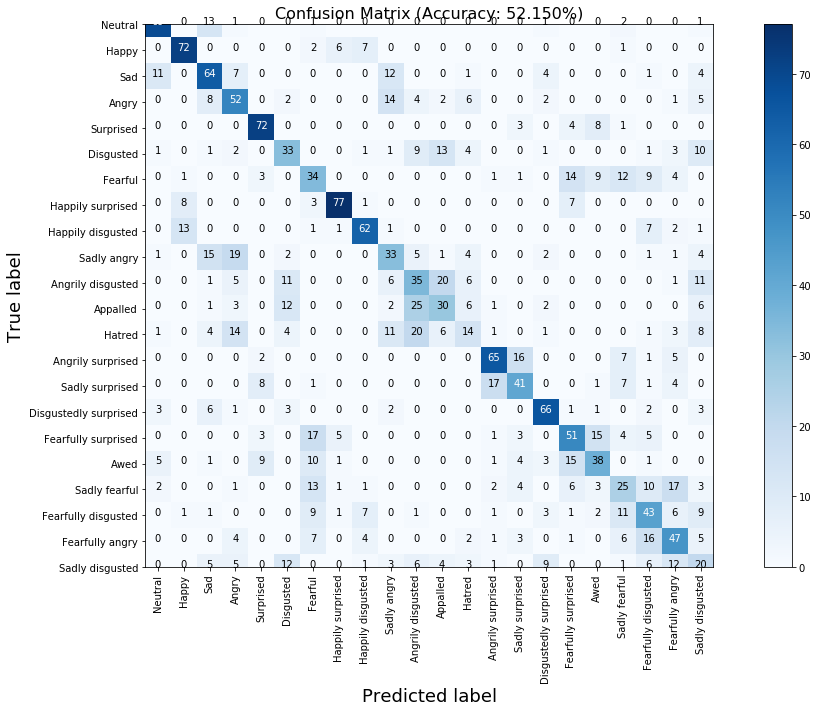

In [37]:
"""
plot confusion_matrix of fold Test set of CK+
"""
import transforms as transforms

import argparse
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix
import sys; sys.argv=['']; del sys

from SPLIT import SPLIT
from models import *

parser = argparse.ArgumentParser(description='PyTorch Project3 CNN Training')
parser.add_argument('--dataset', type=str, default='Project3', help='CNN architecture')
parser.add_argument('--model', type=str, default='VGG19', help='CNN architecture')
opt = parser.parse_args()

cut_size = 44

transform_test = transforms.Compose([
    transforms.TenCrop(cut_size),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
])

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()

class_names = ['Neutral', 'Happy', 'Sad', 'Angry', 'Surprised', 'Disgusted', 'Fearful', "Happily surprised", "Happily disgusted", 
               "Sadly angry", "Angrily disgusted", "Appalled", "Hatred", "Angrily surprised", "Sadly surprised", "Disgustedly surprised", 
              "Fearfully surprised", "Awed", "Sadly fearful", "Fearfully disgusted", "Fearfully angry", "Sadly disgusted"]

# Model
if opt.model == 'VGG19':
    net = VGG('VGG19')
elif opt.model  == 'Resnet18':
    net = ResNet18()

correct = 0
total = 0
all_target = []

for i in range(8):
    print("%d fold" % (i+1))
    path = os.path.join("/home/lingyi/" + opt.dataset + '_' + opt.model,  '%d' %(i+1))

    checkpoint = torch.load(os.path.join(path, 'Test_model.t7'))

    net.load_state_dict(checkpoint['net'].state_dict())
    # net.cuda()
    net.eval()
    testset = SPLIT(split = 'Testing', fold = i+1, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False, num_workers=1)

    for batch_idx, (inputs, targets) in enumerate(testloader):
        bs, ncrops, c, h, w = np.shape(inputs)
        inputs = inputs.view(-1, c, h, w)
        inputs, targets = inputs, targets
        inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        outputs = net(inputs)
        outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
        _, predicted = torch.max(outputs_avg.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        if batch_idx == 0 and i == 0:
            all_predicted = predicted
            all_targets = targets
        else:
            all_predicted = torch.cat((all_predicted, predicted), 0)
            all_targets = torch.cat((all_targets, targets), 0)

        acc = 100. * correct / total
        print("accuracy: %0.3f" % acc)

# Compute confusion matrix
matrix = confusion_matrix(all_targets.data.cpu().numpy(), all_predicted.cpu().numpy())
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(15, 10))
plot_confusion_matrix(matrix, classes=class_names, normalize=False,
                      title= 'Confusion Matrix (Accuracy: %0.3f%%)' %acc)
#plt.show()
# plt.savefig(os.path.join(opt.dataset + '_' + opt.model, 'Confusion Matrix.png'))
# plt.close()


In [40]:
import pickle
with open("/home/lingyi/Desktop/finalize_model/pickles/VGG19_10fold_confusion_matrix.pkl", "wb") as f:
    pickle.dump(matrix, f)

Normalized confusion matrix
[[0.78 0.   0.15 0.01 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
  0.   0.01 0.   0.   0.02 0.   0.   0.01]
 [0.   0.82 0.   0.   0.   0.   0.02 0.07 0.08 0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.01 0.   0.   0.  ]
 [0.11 0.   0.62 0.07 0.   0.   0.   0.   0.   0.12 0.   0.   0.01 0.
  0.   0.04 0.   0.   0.   0.01 0.   0.04]
 [0.   0.   0.08 0.54 0.   0.02 0.   0.   0.   0.15 0.04 0.02 0.06 0.
  0.   0.02 0.   0.   0.   0.   0.01 0.05]
 [0.   0.   0.   0.   0.82 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.03 0.   0.05 0.09 0.01 0.   0.   0.  ]
 [0.01 0.   0.01 0.03 0.   0.41 0.   0.   0.01 0.01 0.11 0.16 0.05 0.
  0.   0.01 0.   0.   0.   0.01 0.04 0.12]
 [0.   0.01 0.   0.   0.03 0.   0.39 0.   0.   0.   0.   0.   0.   0.01
  0.01 0.   0.16 0.1  0.14 0.1  0.05 0.  ]
 [0.   0.08 0.   0.   0.   0.   0.03 0.8  0.01 0.   0.   0.   0.   0.
  0.   0.   0.07 0.   0.   0.   0.   0.  ]
 [0.   0.15 0.   0.   0.   0.   0.01 0.01 0.7  0.01 0.   0.   0.  

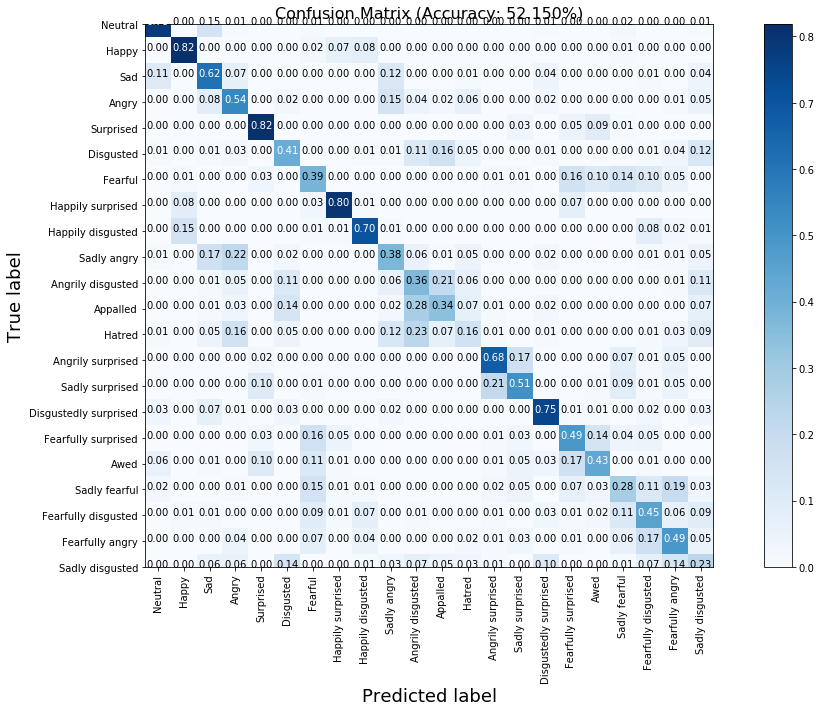

In [42]:
plt.figure(figsize=(15, 10))
plot_confusion_matrix(matrix, classes=class_names, normalize=True,
                      title= 'Confusion Matrix (Accuracy: %0.3f%%)' %acc)

In [75]:
import torch
info = torch.load('/home/lingyi/Desktop/Project3_VGG19/1/Test_model.t7', map_location="cpu")

In [73]:
for i in range(10): 
    
    info = torch.load('/home/lingyi/Desktop/CK+_VGG19/' 
                      + str(i+1) + '/Test_model.t7', map_location="cpu")["best_Test_acc"]
    print(info)

tensor(64.3564)
tensor(54.9505)
tensor(44.5545)
tensor(51.4851)
tensor(41.0891)
tensor(44.0594)
tensor(39.6040)
tensor(48.0198)
tensor(5.9406)
tensor(4.4554)


In [77]:
for i in range(10): 
    
    info = torch.load('/home/lingyi/Desktop/Project3_VGG19/' 
                      + str(i+1) + '/Test_model.t7', map_location="cpu")["best_Test_acc_epoch"]
    print(info)

31
27
35
33
32
36
36
34
31
33


In [76]:
info

{'net': VGG(
   (features): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (9): ReLU(inplace=True)
     (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (12): ReLU(inplace=True)
     (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  